# Strain Dependence of the Graphene Adsorption Potential

In [18]:
# %load ../include/header.py
import numpy as np
import matplotlib.pyplot as plt
from graphenetools import gt
import re,glob,os
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar
import sys,importlib
from collections import defaultdict
from numpy import pi as π
import dgutils

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# plot style
plot_style = {'notebook':'../include/notebook.mplstyle','sans':'../include/sans_NC.mplstyle', 'aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# setup a possible custom font path
font_path,bold_font_path = '.','.'
if 'LOCAL_FONT_PATH' in os.environ:
    font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Light-08.ttf'
    bold_font_path = os.environ['LOCAL_FONT_PATH'] + os.path.sep + 'HelveticaNeue/HelveticaNeue-Bold-02.ttf'

## Load Strain Dependent Potential Parameters from Disk

In [19]:
# get z_min and V_min
data_min = np.load('../data/isotropic_strain_LJ_minimum_info.npz')
δ_z,zmin_z,Vmin_z = data_min['strain'],data_min['z_min'],data_min['V_min'] 

# get σ and ϵ
data_LJ = np.load('../data/isotropic_strain_LJ_params.npz')
δ_LJ,σ_LJ,ϵ_LJ = data_LJ['strain'],data_LJ['sigma'],data_LJ['epsilon']

# perform a simple polynomial fit to the data
zmin_interp =  np.poly1d(np.polyfit(δ_z, zmin_z,2))
Vmin_interp =  np.poly1d(np.polyfit(δ_z, Vmin_z,2))

σ_interp =  np.poly1d(np.polyfit(δ_LJ, σ_LJ,2))
ε_interp =  np.poly1d(np.polyfit(δ_LJ, ϵ_LJ,2))

## Load Strain Dependent Bose-Hubbard Parameters from Disk

In [20]:
δ_BH,t_BH,V_BH,Vp_BH = np.loadtxt('../data/BH_vs_strain.dat',unpack=True)

t_interp =  np.poly1d(np.polyfit(δ_BH, t_BH,4))
V_interp =  np.poly1d(np.polyfit(δ_BH, V_BH,4))
Vp_interp =  np.poly1d(np.polyfit(δ_BH, Vp_BH,4))

## Plot Strain Dependence of Adsorption Potential and LJ Parameters

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


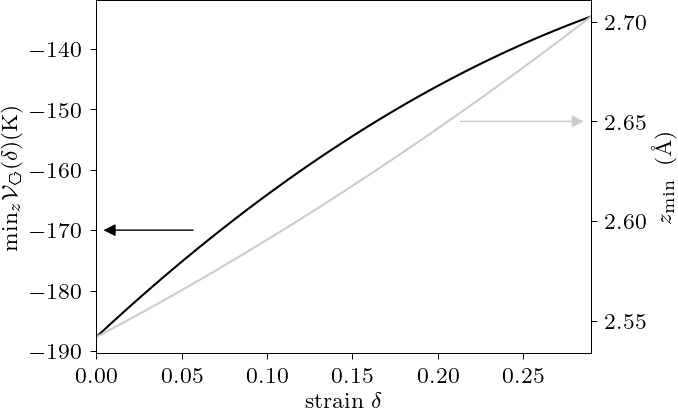

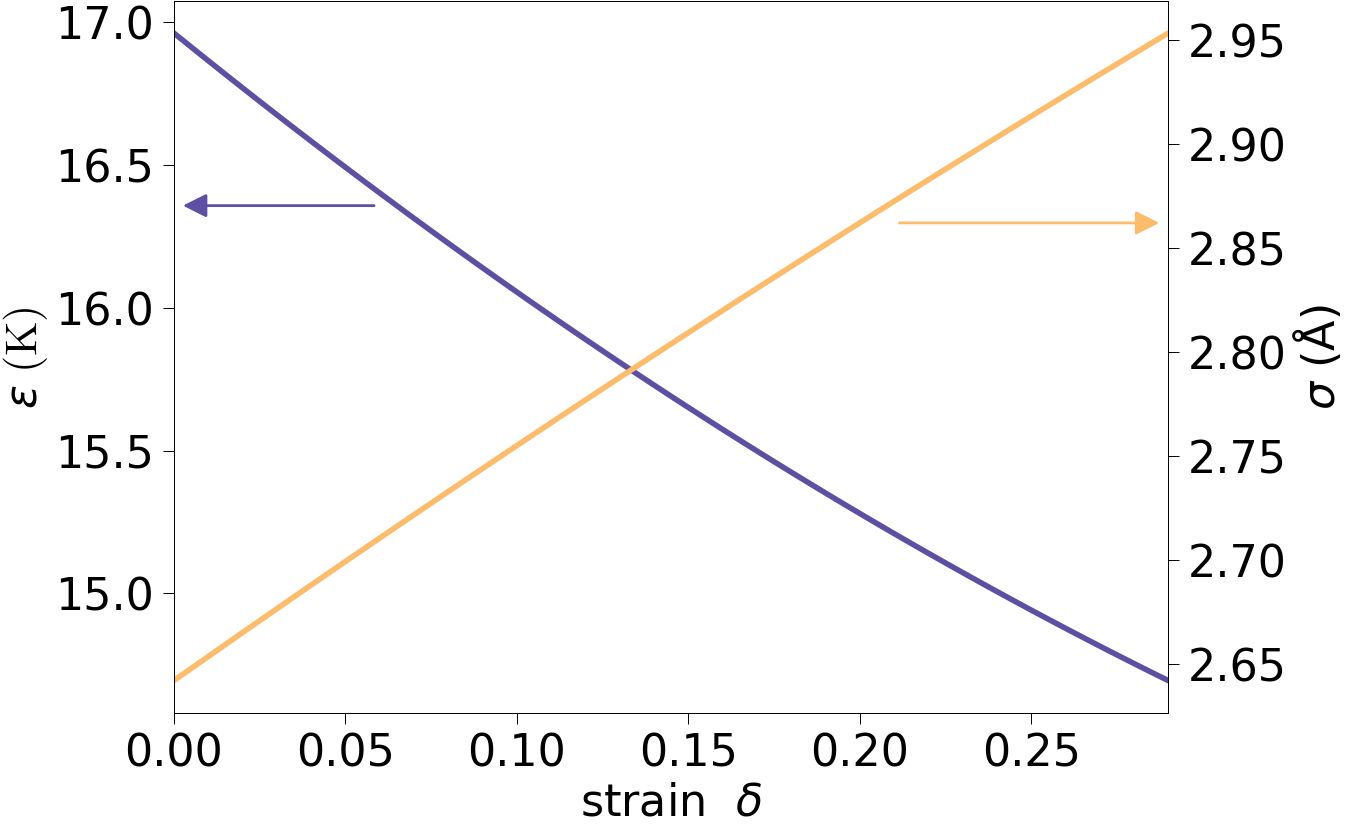

In [26]:
def plot_zmin_Vmin(_ax):
    
    δ = np.linspace(0,0.29,100)
    _ax2 = _ax.twinx()
    
    Vmin_col = '#000000'
    zmin_col = '#CCCCCC'
    
    _ax.plot(δ, Vmin_interp(δ), ls='-', marker='None', mfc='None', color=Vmin_col)
    _ax2.plot(δ, zmin_interp(δ), ls='-', marker='None', mfc='None', color=zmin_col)
    
    # arrows indicating axes
    _ax.annotate("", xy=(0.001,-170), xytext=(0.06, -170), arrowprops=dict(arrowstyle="-|>",color=Vmin_col,lw=0.5))
    _ax2.annotate("", xy=(0.289, 2.65), xytext=(0.21,2.65), arrowprops=dict(arrowstyle="-|>",color=zmin_col,lw=0.5))

    _ax.set_xlabel('strain  $\delta$')
    _ax2.set_ylabel(r'$z_{\rm min}\;\; (\mathrm{\AA})$')
    #_ax.set_ylabel(r'$\min_z \; V_G(0,0,z)\;\; (\mathrm{K})$')
    try:
        _ax.set_ylabel(r'$\min_z \!\mathcal{V}_{\graphene}(\delta) (\mathrm{K})$')
    except:
        _ax.set_ylabel(r'$\min_z \!\mathcal{V}_{\rm G}(\delta) (\mathrm{K})$')

    _ax.set_xlim(0,0.29)
    
    return _ax
    
def plot_σ_ε(_ax):
    
    δ = np.linspace(0,0.29,100)
    _ax2 = _ax.twinx()
    
    _ax.plot(δ, ε_interp(δ), ls='-', marker='None', mfc='None', color=colors[0])
    _ax2.plot(δ, σ_interp(δ), ls='-', marker='None', mfc='None', color=colors[6])

    # arrows indicating axes
    _ax.annotate("", xy=(0.001,ϵ_interp(0.065)), xytext=(0.06, ϵ_interp(0.065)), arrowprops=dict(arrowstyle="-|>",color=colors[0]))
    _ax2.annotate("", xy=(0.289, σ_interp(0.2)), xytext=(0.21,σ_interp(0.2)), arrowprops=dict(arrowstyle="-|>",color=colors[6]))

    _ax.set_xlabel('strain  $\delta$')
    _ax.set_ylabel(r'$\varepsilon\; (\mathrm{K})$')
    _ax2.set_ylabel(r'$\sigma$ (Å)')
    _ax.set_xlim(0,0.29)
    
    return _ax
    
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    ax = plot_zmin_Vmin(ax)
    plt.savefig('../figures/zmin_vs_strain.pdf')
    
with plt.style.context(plot_style['notebook']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    ax = plot_σ_ε(ax)
    plt.savefig('../figures/LJ_vs_strain.pdf')

## Plot the xy-Averaged Value of the Potential

In [11]:
def V0_graphene(z,ε=16.968,σ=2.642,aₒ=1.42):
    A = 3*np.sqrt(3)*aₒ*aₒ/2
    return (4*π/A)*ε*σ*σ*( (2/5)*(σ/z)**10 - (σ/z)**4 )

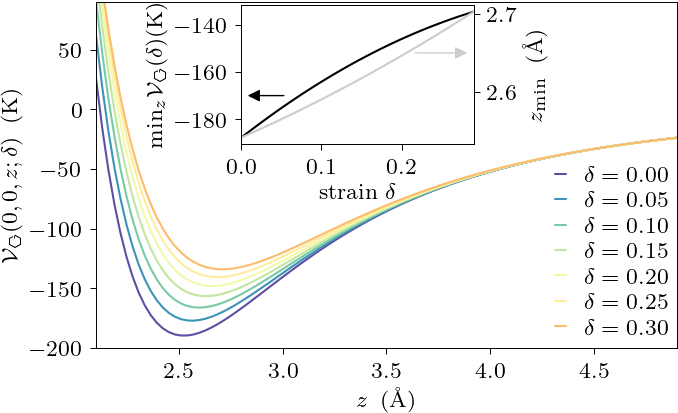

In [12]:
def plot_Vads(_ax, add_inset=False):
    z = np.linspace(2.1,5,100)
    aₒ = 1.42
    V_64 = np.vectorize(gt.V_64)
    
    for cδ in np.linspace(0,0.30,7):
        #_V = V0_graphene(z,ε=ε_interp(cδ),σ=σ_interp(cδ),aₒ=aₒ*(1+cδ))
        _V = V_64(0.0,σ_interp(cδ),ε_interp(cδ),0.0,0.0,z,carbon_carbon_distance=aₒ*(1+cδ))

        _ax.plot(z,_V, label=f'$\delta = {cδ:.2f}$')

    _ax.set_xlabel(r'$z \;\; (\mathrm{\AA})$')
    _ax.set_ylabel(r'$\mathcal{V}_{\graphene}(0,0,z;\delta) \;\; (\mathrm{K})$')
    
    _ax.set_ylim(-200,90)
    _ax.set_xlim(2.1,4.9)

    _ax.legend(ncol=1,loc=(0.775,0.0025), columnspacing=0.5, handlelength=0.5, labelspacing=0.25)
    
    if add_inset:
        _axins = ax.inset_axes([0.25, 0.59, 0.4, 0.4])
        _axins = plot_zmin_Vmin(_axins)
        
    return _ax
        
        
with plt.style.context(plot_style['aps']):
    fig,ax = plt.subplots(1,1,constrained_layout=True)
    #dgutils.fonts.set_custom_font(font_path)

    ax = plot_Vads(ax, add_inset=True)
    plt.savefig('../figures/VG_vs_z_with_inset.pdf')
    

## Investigate the Strain Dependence of the BH Parameters

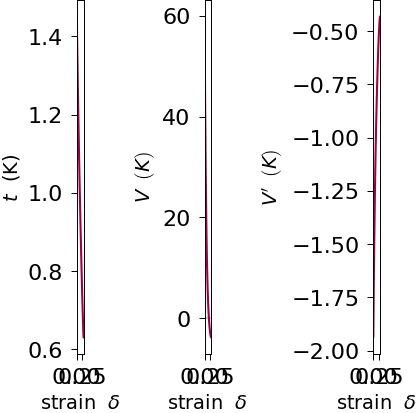

In [16]:
def plot_BH_strain(_fig, rel=False, semi_classical=False):    
    axd = _fig.subplots(nrows=1,ncols=3, sharex=True, sharey=False)    
    axd = axd.flat
    aₒ = 1.42

    δ = np.linspace(0,0.3,100)
    
    norm = [1.0,1.0,1.0]
    y_labels = [r'$t$  (K)',r'$V\;\; (K)$',r'$V^\prime\;\; (K)$']
    
    if rel:
        #y_labels = [r'$t(\delta)/t(0)$  (K)',r'$V(\delta)/V(0)\;\; (K)$',r'$V^\prime(\delta)/V^\prime(0)\;\; (K)$']
        y_labels = [r'$t\,/\,t_0$',r'$V\,/\,V_0$',r'$V^{\prime}\,/\,V^{\prime}_0$']
        norm = [t_interp(0),V_interp(0),Vp_interp(0)]

        
    axd[0].plot(δ,t_interp(δ)/norm[0],color=colors[-1])
    axd[1].axhline(y=0,color="#CCCCCC", linestyle=':', zorder=-10)
    axd[1].plot(δ,V_interp(δ)/norm[1],color=colors[-1], label='HF')
    axd[2].plot(δ,Vp_interp(δ)/norm[2],color=colors[-1])
    

    # Add the semi-classical adsorption potential
    if semi_classical:
        from heprops import helium,potential

        V = potential.szalewicz_2012
        norm = [1.0,1.0]
        if rel:
            norm = [V(np.sqrt(3)*aₒ),V(3*aₒ)]
            
        axd[1].plot(δ,V(np.sqrt(3)*aₒ*(1+δ))/norm[0],color=colors[-1],linestyle='--',alpha=0.6, label='SC')
        axd[2].plot(δ,V(3*aₒ*(1+δ))/norm[1],color=colors[-1],linestyle='--',alpha=0.6)
        axd[1].legend()
    
    axd[0].set_xlim(0,0.299)    
  
    for i in range(3):
        axd[i].set_xlabel('strain  $\delta$')
        axd[i].set_ylabel(y_labels[i])

    return axd

plt.style.reload_library()
with plt.style.context(plot_style['sans']):
    
    figsize = plt.rcParams['figure.figsize']
    fig = plt.figure(figsize=(figsize[1],figsize[1]),constrained_layout=True)
    #dgutils.fonts.set_custom_font(font_path)
    plot_BH_strain(fig)

## Construct the Combined Figure

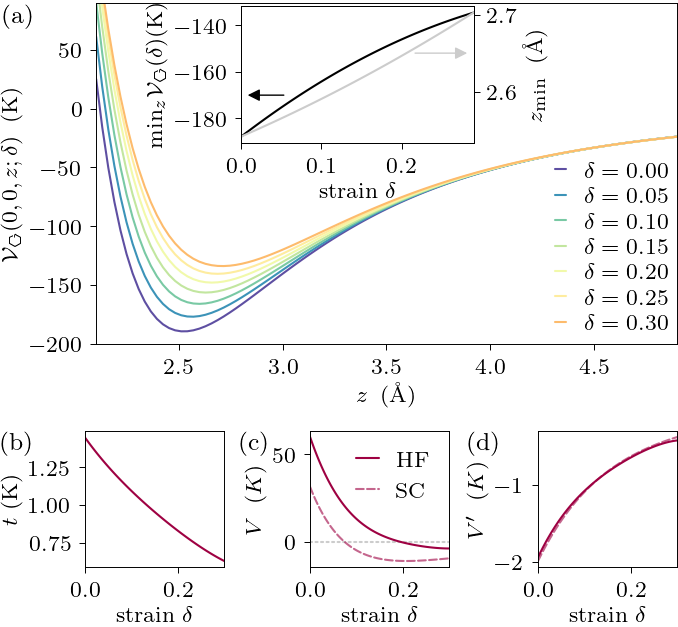

In [17]:
plt.style.reload_library()
with plt.style.context(plot_style['aps']):
    
    #dgutils.fonts.set_custom_font(font_path)

    figsize = plt.rcParams['figure.figsize']
    fig = plt.figure(figsize=(figsize[0],1.5*figsize[1]), constrained_layout=True)
    VG_fig,BH_fig = fig.subfigures(nrows=2,ncols=1, height_ratios=[2,1])
    
    # Graphene Adsorption Figure
    ax_VG = VG_fig.subplots(1,1) 
    ax_VG = plot_Vads(ax_VG)
    
    # Add Inset with Vmin
    axins = ax_VG.inset_axes([0.25, 0.59, 0.4, 0.4])
    axins = plot_zmin_Vmin(axins)
    
    # Bose-Hubbard
    ax_BH = plot_BH_strain(BH_fig,rel=False, semi_classical=True)
    
    # add panel labels
    font_props = dgutils.fonts.get_custom_font_props(bold_font_path)
    ax_VG.text(-0.16,1.0,'(a)', ha='left',va='top', transform=ax_VG.transAxes, fontproperties=font_props)    
    ax_BH[0].text(-0.60,1.0,'(b)',ha='left',va='top',transform=ax_BH[0].transAxes, fontproperties=font_props)
    for i,lab in enumerate(['(c)','(d)']):
        ax_BH[i+1].text(-0.50,1.0,lab,ha='left',va='top',transform=ax_BH[i+1].transAxes, fontproperties=font_props)
    
    plt.savefig('../figures/VG_vs_z_BH.pdf')